In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.svm import SVC

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cancer-patients-and-air-pollution-a-new-link/cancer patient data sets.csv


In [5]:
data=pd.read_csv('/kaggle/input/cancer-patients-and-air-pollution-a-new-link/cancer patient data sets.csv')

In [6]:
print(data.head())
print(data.describe())
print(data.info())

   index Patient Id  Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0      0         P1   33       1              2            4             5   
1      1        P10   17       1              3            1             5   
2      2       P100   35       1              4            5             6   
3      3      P1000   37       1              7            7             7   
4      4       P101   46       1              6            8             7   

   OccuPational Hazards  Genetic Risk  chronic Lung Disease  ...  Fatigue  \
0                     4             3                     2  ...        3   
1                     3             4                     2  ...        1   
2                     5             5                     4  ...        8   
3                     7             6                     7  ...        4   
4                     7             7                     6  ...        3   

   Weight Loss  Shortness of Breath  Wheezing  Swallowing Difficulty

In [7]:
data=data.drop(columns=['index','Patient Id'],axis=1)
print(data.shape)

(1000, 24)


In [9]:
y=data['Level']
data=data.drop(columns=['Level'])

KeyError: 'Level'

In [10]:
print(data.shape)

(1000, 23)


In [11]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y=pd.DataFrame(y)

In [12]:
train_x,temp_x,train_y,temp_y=train_test_split(data,y,train_size=0.7,random_state=42)
test_x,val_x,test_y,val_y=train_test_split(temp_x,temp_y,train_size=0.5,random_state=42)

building random forest model

In [13]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [14]:
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics=['categorical_accuracy'])

Use /tmp/tmpcocaznxr as temporary training directory


In [15]:
rf.fit(x=train_x.values,y=train_y.values,validation_data=(val_x.values,val_y.values))

Reading training dataset...
Training dataset read in 0:00:07.926329. Found 700 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(150, shape=(), dtype=int32)
Validation dataset read in 0:00:00.550641. Found 150 examples.
Training model...
Model trained in 0:00:00.174510
Compiling model...


[INFO 24-01-29 05:16:27.3954 UTC kernel.cc:1243] Loading model from path /tmp/tmpcocaznxr/model/ with prefix a51df12f6b9d4bc2
[INFO 24-01-29 05:16:27.4292 UTC decision_forest.cc:660] Model loaded with 300 root(s), 7060 node(s), and 23 input feature(s).
[INFO 24-01-29 05:16:27.4293 UTC abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 24-01-29 05:16:27.4293 UTC kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [ ]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()

In [16]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=700, accuracy=1.0, loss=0.012405749535454171, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [17]:
predictions=rf.predict(test_x)
predictions=np.argmax(predictions,axis=1)

5/5 [==============================] - 0s 3ms/step


In [18]:
test_y=test_y.values.flatten()

In [19]:

print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



Building SVM model

In [20]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', C=1.0)

In [25]:
svm_classifier.fit(train_x.values,train_y.values.flatten())

SVC(kernel='linear')

In [26]:
print(accuracy_score(test_y,svm_classifier.predict(test_x)))

1.0


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


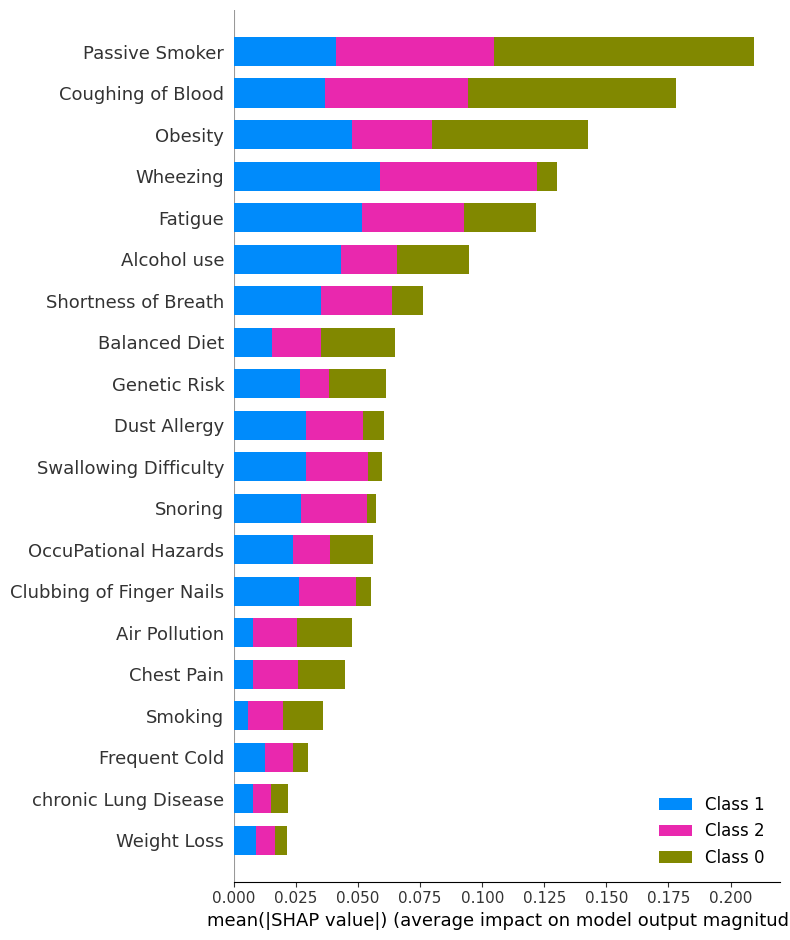

In [32]:
import shap
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(train_x, train_y.values.flatten())
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)

# Visualize the summary plot
shap.summary_plot(shap_values, test_x, feature_names=test_x.columns)

low - 1
medium - 2
high - 0